In [53]:
#importing matplotlib and applying seaborn style for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')
import matplotlib.patches as patches
import scipy
import numpy as np
import math
from PIL import Image

In [54]:
#=====================SENSOR PARAMETERS===================== Example: ZWO ASI 6200MM

pixel_size = 3.76*10**(-6) #in meters
Q_efficiency = 0.5*0.9 #fraction of incoming photons that elevate electrons in any given pixel by the P.E. effect, accounts for sensor QE = 0.5 , optics transmissivity = 0.9
read_noise = 1.5 #electrons/pixel
gain = 0.779 #electrons/ADU
sensor_offset = 500
dark_noise = 0.0010 #electrons/second/pixel
full_well = 51000 #maximum number of electrons
sensor_X = 40 #sensor width in pixels 4007
sensor_Y = 40 #sensor height in pixels 2671

sensor_width = sensor_X*pixel_size #Sensor width in m
sensor_height = sensor_Y*pixel_size #Sensor height in m


In [55]:
#=====================OBSERVATORY PARAMETERS===================== Example: AG Optical FA12 12.5" Harmer Wynne

scope_dia = 0.3175 #telescope diameter in metres
mirror_area = np.pi*(scope_dia/2)**2
scope_focal = 1.570 #telescope focal length in meters
f_ratio = scope_focal/scope_dia #compute focal ratio of the telescope
plate_scale = 0.488 #arcsec/pixel


In [56]:
#=====================FILTER PARAMETERS===================== Example: ASTRODON Gen2 'G' Filter

filter_low = 490*1*10**(-9) #filter lower bound wavelength in meters
filter_low_freq = scipy.constants.c/filter_low

filter_high = 560*10**(-9) #filter upper bound wavelength in meters
filter_high_freq = scipy.constants.c/filter_high

filter_zero = 3781 #zero point flux for fitler, Jansky = 10^(-26) W/m^2/Hz
filter_freq_band = filter_low_freq-filter_high_freq




In [57]:
#=====================TARGET PARAMETERS===================== Example: 16-Lmi

#Star is completely characterized by its temperature, distance and size
#You can use other metrics to completely characterize it if these measurements are unavailable, however they are the most convenient to use

obs_type = 0 # 0 FOR EXTENDED SOURCE, 1 FOR POINT SOURCE

star_dist = 1487.4 #Lightyears #1487.4
star_dist_m = star_dist*9.461*10**15 #star distance in meters
star_temp = 4043.85 #Temperature in Kelvin
star_dia_solar = 67.08 #solar diameters of star #2.3
star_dia = 1.3927*10**9*star_dia_solar #diameter in m of the star

#NOT NEEDED:
#star_abs_mag = 5
#star_suns = 10**(0.4*(4.85 - star_abs_mag))
#star_lum = star_suns*3.827*10**26 #star luminosity in W
#star_flux = star_lum/(4*np.pi*star_dist_m**2) #flux in Joules per second per m^2

In [58]:
#===================== COMPUTE FOV (arcseconds) =====================
#Using Focal length, pixel size and sensor dimensions

FOV_width = 206265*sensor_width*(1/scope_focal)
FOV_height = 206265*sensor_height*(1/scope_focal)

FOV_area = FOV_width*FOV_height

In [59]:
#===================== SKY PARAMETERS ===================== Example: Animas, NM, USA

sky_bright = 21.75 #sky brightness (mag/arcsec^2) Source: https://www.lightpollutionmap.info/ #20.87 for GAO site
seeing_cond = 5 #seeing condition reported in FWHM (arcsec)
seeing_pixel = seeing_cond/plate_scale #FWHM of star in pixels

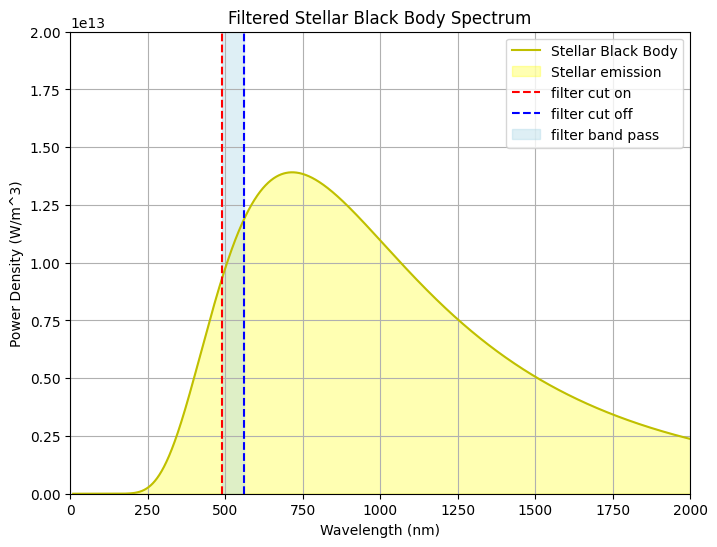

In [60]:
#=====================PLOT LIGHT CURVE STAR BROADBAND=====================

kB = scipy.constants.Boltzmann
h = scipy.constants.Planck
c = scipy.constants.c
T = star_temp

#define the wavelenths of evaluation
wl = np.linspace(1*10**(-8),5*10**(-6),10000) #compute wavelength bandpass
wlnm = wl*10**9 #wavelengths in nm for plotting clarity

P = ((2*np.pi*h*c**2)/(wl**5))*(1/(np.exp((h*c)/(wl*kB*T))-1))

#plot the power density against wavelength
#set x axis points in nm for readability


plt.figure(figsize=(8, 6))
plt.plot(wlnm, P, label='Stellar Black Body',color='y')
plt.fill_between(wlnm, P, color = 'yellow', alpha = 0.3,label = 'Stellar emission')

plt.axvline(x=filter_low*10**9, color='r', linestyle='--', label='filter cut on')
plt.axvline(x=filter_high*10**9, color='b', linestyle='--', label='filter cut off')

plt.fill_betweenx(y=np.linspace(min(P), max(P)+1*10**14), x1=filter_low*10**9, x2=filter_high*10**9, color='lightblue', alpha=0.4, label='filter band pass')

plt.title('Filtered Stellar Black Body Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power Density (W/m^3)')
plt.xlim(0,2000)
plt.ylim(0,0.2*10**14)

plt.legend()
plt.grid(True)
plt.show()

In [61]:
#INTEGRATE TO FIND ENTIRE STAR ENERGY, INTEGRATE OVER BAND PASS TO FIND PORTION OF INCOMING STAR EMERGY RECEIVED

In [62]:
#INTEGRATE OVER BANDPASS

#define wavelengths by dividing the bandpass range into 1000 equal parts
wlB = np.linspace(filter_low,filter_high,1000)

#define the step width as the distance between adjacent wavelength values
stepWidth = (wlB[1]-wlB[0]) #distance from 1 point to the next = step size

#Calculate the photon energies at every wavelength
p_Energy = h*c/wlB

#calculate the integrand under the Stefan-Boltzmann (SB) law, divided by the photon energies for total number of photons
PB = ((2*np.pi*h*c**2)/(wlB**5))*(1/(np.exp((h*c)/(wlB*kB*T))-1))*(1/(p_Energy)) #coarse function values, 100 segments



In [63]:
#function computing the integral of a function f using the trapezoidal rule, taking in the function and a step size.
def computeIntegral(f,stepSize):
    return (stepSize/2)*(f[0]+f[-1]+2*np.sum(f[1:-1]))


In [64]:
counts_per_second = computeIntegral(PB,stepWidth)*(4*np.pi*((star_dia/2)**2))/(4*np.pi*star_dist_m**2)*mirror_area*Q_efficiency/gain #electrons per second from the star on the sensor in photons/m^2

In [65]:
print('The sensor reports', math.trunc(counts_per_second), 'counts per second from the star.')

The sensor reports 996636 counts per second from the star.


In [66]:
#SPREAD COUNTS OVER A 2D GAUSSIAN
#Takes in sensor dimensions, total counts to spread, and fwhm (seeing condition)

def spreadCounts(sensorX, sensorY, totalCounts, fwhm, exposureTime, fullWell, obsType):
    
    if obsType == 1: # POINT SOURCE

        sigma = fwhm/(2*np.sqrt(2*np.log(2)))
        signalValues = np.zeros([sensorY,sensorX])
        centerX = sensorY/2
        centerY = sensorX/2

        for x in range(sensorY):
            for y in range(sensorX):
                signalValues[x,y] = (1/(2*np.pi*sigma**2))*np.exp((-((x-centerX)**2+(y-centerY)**2))/(2*sigma**2))

        signalValues = signalValues*(totalCounts/signalValues.sum())*exposureTime
        return signalValues
    
    elif obsType == 0: # EXTENDED SOURCE

        signalValues = totalCounts #Assumes area of interest is at the center of the detector.
        return signalValues


In [67]:
#GENERATE CCD NOISE
#Takes in sensor parameters and generates signal noise based on exposure time

def generateNoise(sensorX, sensorY, darkCurrent, readNoise, offset, exposureTime, obsType):
    
    if obsType == 1: # Point Source
    
        noiseValues = np.zeros([sensorY,sensorX])
    
        for x in range(sensorY):
            for y in range(sensorX):
                noiseValues[x,y] = np.random.normal(0,readNoise) + np.random.normal(0,darkCurrent)*exposureTime + offset

        return noiseValues
    
    elif obsType == 0: # Extended source

        noiseValues = readNoise + (darkCurrent*exposureTime) + offset
        return noiseValues

In [68]:
#GENERATE SKY BACKGROUND EMISSION
#Takes in sensor, telescope, sky and filter parameters and generates sky background signal based on exposure time and bortle scale

def generateBG(sensorX, sensorY, skyMag, zeroFlux, mirrorArea, sensorGain, filterLow, filterHigh, sensorQE, freqPass, exposureTime, obsType):

    if obsType == 1: # Point Source

        skyBG = np.zeros([sensorY,sensorX])
        skyFlux = zeroFlux*10**(-0.4*skyMag)*10**(-26)*(freqPass)*mirrorArea
        skyCounts = skyFlux/(scipy.constants.h*scipy.constants.c/(filter_low+((filterHigh-filterLow)/2)))*sensorQE*exposureTime/sensorGain #counts from the sky per second
    
        for x in range(sensorY):
            for y in range(sensorX):
                skyBG[x,y] = skyCounts

        return skyBG
    
    elif obsType == 0: # Extended Source

        skyBG = 0
        skyFlux = zeroFlux*10**(-0.4*skyMag)*10**(-26)*(freqPass)*mirrorArea
        skyCounts = skyFlux/(scipy.constants.h*scipy.constants.c/(filter_low+((filterHigh-filterLow)/2)))*sensorQE*exposureTime/sensorGain #counts from the sky per second
        skyBG = skyCounts

        return skyBG
        

        

In [69]:
#CHECK FOR OVERFULL PIXELS
#Takes in signal, bg noise and sensor noise and checks if any pixels exceed full well. Assumes perfect blooming correction of the sensor

def overfullCheck(arrayTest, fullWell, obsType):

    if obsType == 1: # Point Source

        for x in range(len(arrayTest)):
            for y in range(len(arrayTest[0])):
                if arrayTest[x,y] > fullWell:
                    arrayTest[x,y] = fullWell

        return arrayTest
    
    elif obsType == 0: # Extended Source

        if arrayTest > fullWell:
            arrayTest = fullWell

        return arrayTest

In [70]:
#COMPUTE SIGNAL, NOISE, BACKGROUND ARRAYS FOR TEST IMAGE (1s):

test_exposure = 1

In [71]:
signal_values = spreadCounts(sensor_X,sensor_Y,counts_per_second,seeing_pixel,test_exposure,full_well,obs_type)

In [73]:
noise_values=generateNoise(sensor_X,sensor_Y,dark_noise,read_noise,sensor_offset,test_exposure, obs_type)

In [74]:
bg_values = generateBG(sensor_X,sensor_Y,sky_bright,filter_zero,mirror_area,gain,filter_low,filter_high,Q_efficiency,filter_freq_band,test_exposure,obs_type)

In [75]:
final_sensor_array = overfullCheck(signal_values+noise_values+bg_values,full_well,obs_type)

In [76]:
#GENERATE APERTURE FOR MEASURING SNR

aperture_rad = seeing_pixel*0.67
aperture_center = (sensor_X/2,sensor_Y/2)
aperture_num_pixels = np.pi*aperture_rad**2

In [77]:
aperture_circle = patches.Circle(aperture_center,radius=aperture_rad, edgecolor = 'red', facecolor = 'none', linewidth = 1)
plt.figure(figsize=(12, 10))
plt.text(aperture_center[0]+8,aperture_center[1]+8, 'Measurement Aperture', verticalalignment='center',color='red')
plt.imshow(final_sensor_array, cmap='gray', interpolation='nearest',vmin = 0)
plt.gca().add_patch(aperture_circle)
plt.colorbar(label='Counts')
plt.title('Spread of Counts over Sensor')
plt.xlabel('Number of pixels (X)')
plt.ylabel('Number of pixels (Y)')
plt.xlim(0,sensor_X)
plt.ylim(0,sensor_Y)
plt.gca().set_aspect('equal')
plt.show()

TypeError: Invalid shape () for image data

Error in callback <function flush_figures at 0x11c084cc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [78]:
print("The peak number of counts in the simulated image is: ",np.max(final_sensor_array))
print("The minimum number of counts in the simulated image is: ",np.min(final_sensor_array))

The peak number of counts in the simulated image is:  51000
The minimum number of counts in the simulated image is:  51000


In [111]:
def computeSNR(exposureTime, signalCountsPerSec=counts_per_second, apertureNumPixels=aperture_num_pixels, readNoise = read_noise, darkNoise = dark_noise, obsType=obs_type):


    if obsType == 1: # Point source

        return (signalCountsPerSec*exposureTime)/(np.sqrt(signalCountsPerSec*exposureTime+apertureNumPixels*(exposureTime*generateBG(sensor_X,sensor_Y,sky_bright,filter_zero,mirror_area,gain,filter_low,filter_high,Q_efficiency,filter_freq_band,exposureTime,obs_type)[0][0]+readNoise**2+exposureTime*darkNoise)))
    
    elif obsType == 0: # Extended

        return (signalCountsPerSec*exposureTime)/(np.sqrt(signalCountsPerSec*exposureTime+(exposureTime*generateBG(sensor_X,sensor_Y,sky_bright,filter_zero,mirror_area,gain,filter_low,filter_high,Q_efficiency,filter_freq_band,exposureTime,obs_type)+readNoise**2+exposureTime*darkNoise)))
   

In [112]:
if obs_type == 1: # Point Source

    SNR_ref = (counts_per_second*test_exposure)/(np.sqrt(counts_per_second*test_exposure+aperture_num_pixels*(test_exposure*bg_values[0][0]+read_noise**2+test_exposure*dark_noise)))
    print("The SNR of the reference image is: ", SNR_ref)

elif obs_type == 0: # Extended Source

    SNR_ref = (counts_per_second*test_exposure)/(np.sqrt(counts_per_second*test_exposure+(test_exposure*bg_values+read_noise**2+test_exposure*dark_noise)))
    print("The SNR of the reference image is: ", SNR_ref)   



The SNR of the reference image is:  998.315464461911


In [ ]:
#CHECK FOG LIMIT AND CALCULATE EXPOSURE TIME
#If a star is too dim or the sky too bright, SNR will plateau. This code checks to see if the desired SNR is above this limit. Assumes maximum exposure time of 300 hours.
#If Desired SNR is above the fog limit, a lower SNR must be input or better conditions observed.
#This function iterates over SNR calculations until the desired SNR is achieved within a tolerance, default Tolerance = 1

In [114]:
def calculateReqTime(desiredSNR, snrRef, expRef, tolerance = 1, maxTime = 1080000):
    
    maxSNR = computeSNR(maxTime)
    currentSNR = snrRef

    if desiredSNR>maxSNR:
        return "SNR not achievable"


    else:
        while np.abs(desiredSNR-currentSNR)>tolerance:
            currentTime = expRef*(desiredSNR/currentSNR)**2
            currentSNR = computeSNR(currentTime)
            expRef = currentTime
            print("SNR is now: ",currentSNR)
            


        print("The calculated exposure time is: ")
        return currentTime
        

In [115]:
#Calculate exposure time for desired SNR using function.
desired_SNR = 1050
calculateReqTime(desired_SNR, SNR_ref, test_exposure)

SNR is now:  1050.0000747876802
The calculated exposure time is: 


1.1062238075467588

In [116]:
#IMPORT REAL DATA
def open_image(imagePath):
    # Open the image
    with Image.open(imagePath) as img:
        # Convert image to grayscale
        imgGray = img.convert('L')
        # Convert the image data to a 2D numpy array
        pixelValues2D = np.array(imgGray)
        return pixelValues2D

#Open data
image_path = '1second.png'
image_data = open_image(image_path)*(full_well/255)

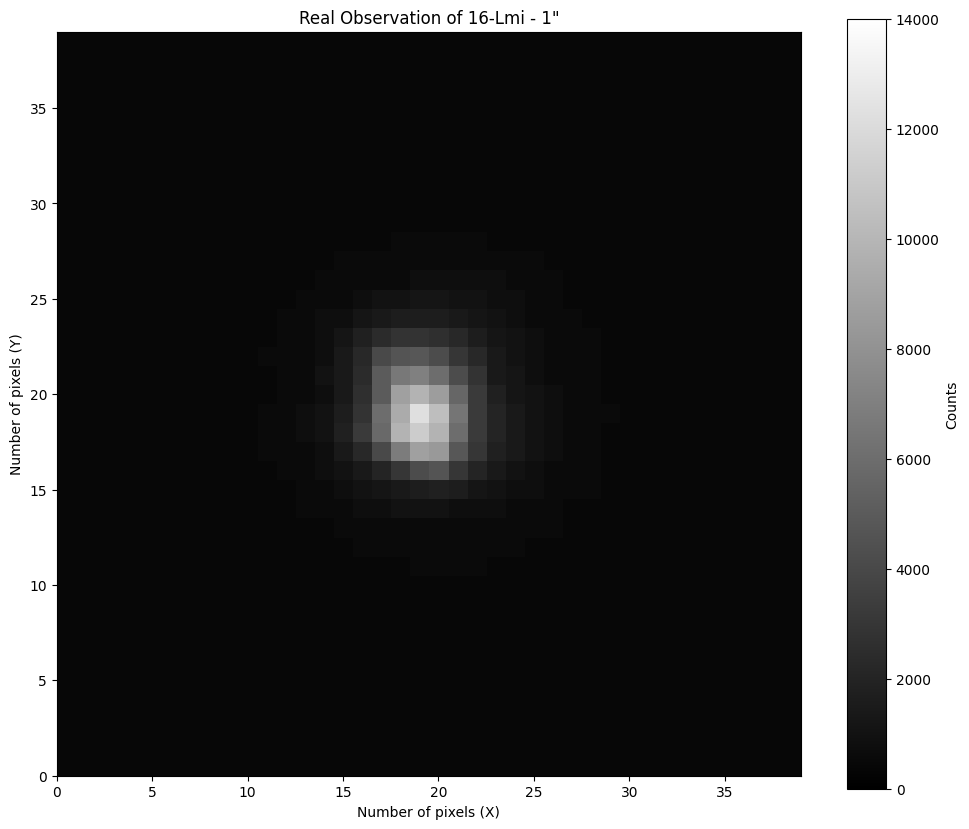

The peak number of counts in the real image is:  12200.0
The minimum number of counts in the real image is:  400.0


In [ ]:
plt.figure(figsize=(12, 10))
#plt.text(aperture_center[0]+8,aperture_center[1]+8, 'Measurement Aperture', verticalalignment='center',color='red')
plt.imshow(image_data, cmap='gray', interpolation='nearest',vmin = 0,vmax=14000)
#plt.gca().add_patch(aperture_circle)
plt.colorbar(label='Counts')
plt.title('Real Observation of 16-Lmi - 1"')
plt.xlabel('Number of pixels (X)')
plt.ylabel('Number of pixels (Y)')
plt.xlim(0,sensor_X-1)
plt.ylim(0,sensor_Y-1)
plt.gca().set_aspect('equal')
plt.show()

print("The peak number of counts in the real image is: ",np.max(image_data))
print("The minimum number of counts in the real image is: ",np.min(image_data))